In [15]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Loading DataSet

In [16]:
data = pd.read_csv('Dow Jones Industrial Average Historical Data.csv')

In [17]:
print(data.columns)

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')


Implementing Preprocessing Steps

In [18]:
# Converting 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

In [19]:
# Checking data types and dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2434 entries, 0 to 2433
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2434 non-null   datetime64[ns]
 1   Price     2434 non-null   object        
 2   Open      2434 non-null   object        
 3   High      2434 non-null   object        
 4   Low       2434 non-null   object        
 5   Vol.      2434 non-null   object        
 6   Change %  2434 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 133.2+ KB


In [20]:
# Checking null values
data.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [21]:
# Creating lag features
data['Price_Lag_1'] = data['Price'].shift(1)
data['Price_Lag_2'] = data['Price'].shift(2)
data['Change_Lag_1'] = data['Change %'].shift(1)

In [22]:
# Removing commas from 'Price', 'Open', 'High', 'Low', and cast them to float
data['Price'] = data['Price'].str.replace(',', '').astype(float)
data['Open'] = data['Open'].str.replace(',', '').astype(float)
data['High'] = data['High'].str.replace(',', '').astype(float)
data['Low'] = data['Low'].str.replace(',', '').astype(float)

In [23]:
# Cleaning and converting 'Vol.' to a numeric value (in millions or billions)
data['Vol.'] = data['Vol.'].replace({'M': '*1e6', 'B': '*1e9'}, regex=True).map(pd.eval).astype(float)

# Cleaning 'Change %' and converting it to float
data['Change %'] = data['Change %'].str.replace('%', '').astype(float)

# Sorting the data by date in ascending order
djia_data = data.sort_values('Date')
djia_data.head()

,Date,Price,Open,High,Low,Vol.,Change %,Price_Lag_1,Price_Lag_2,Change_Lag_1
2433,2015-01-20,17515.23,17516.96,17588.70,17346.73,119600000.0,0.02,"17,554.28","17,813.98",0.22%
2432,2015-01-21,17554.28,17509.96,17599.58,17396.04,95530000.0,0.22,"17,813.98","17,672.60",1.48%
2431,2015-01-22,17813.98,17557.29,17840.89,17482.54,111980000.0,1.48,"17,672.60","17,678.70",-0.79%
2430,2015-01-23,17672.60,17812.50,17812.50,17667.53,97110000.0,-0.79,"17,678.70","17,387.21",0.03%
2429,2015-01-26,17678.70,17668.11,17696.36,17567.60,87220000.0,0.03,"17,387.21","17,191.37",-1.65%


In [24]:
# Descriptive Statistics
data.describe()

,Date,Price,Open,High,Low,Vol.,Change %
count,2434,2434.000000,2434.000000,2434.000000,2434.000000,2.434000e+03,2434.000000
mean,2019-11-18 05:49:38.800328704,27289.371150,27285.286027,27431.730867,27130.918796,2.975425e+08,0.042161
min,2015-01-20 00:00:00,15660.180000,15676.260000,15897.820000,15370.330000,4.035000e+07,-12.930000
25%,2017-06-19 06:00:00,21188.167500,21170.212500,21312.205000,21114.597500,2.359125e+08,-0.380000
50%,2019-11-16 12:00:00,26499.135000,26496.245000,26612.535000,26381.760000,3.039050e+08,0.070000
75%,2022-04-18 18:00:00,33699.122500,33704.182500,33872.892500,33472.452500,3.621400e+08,0.547500
max,2024-09-19 00:00:00,42025.190000,41972.560000,42160.910000,41832.090000,9.226800e+08,11.370000
std,NaN,6892.293481,6890.274974,6925.065651,6857.292341,1.325434e+08,1.112673


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2434 entries, 0 to 2433
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2434 non-null   datetime64[ns]
 1   Price         2434 non-null   float64       
 2   Open          2434 non-null   float64       
 3   High          2434 non-null   float64       
 4   Low           2434 non-null   float64       
 5   Vol.          2434 non-null   float64       
 6   Change %      2434 non-null   float64       
 7   Price_Lag_1   2433 non-null   object        
 8   Price_Lag_2   2432 non-null   object        
 9   Change_Lag_1  2433 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(3)
memory usage: 190.3+ KB


In [35]:
# Feature Engineering
data['Rolling_Mean_5'] = data['Price'].rolling(window=5).mean()
data['Rolling_Std_5'] = data['Price'].rolling(window=5).std()



data['Pct_Change_5'] = data['Price'].pct_change(periods=5)
data['Volatility_5'] = data['Change %'].rolling(window=5).std()

# Drop missing values
data.dropna(inplace=True)

print(data.head())

        Date     Price      Open      High       Low         Vol.  Change %  \
5 2024-09-12  41096.77  40862.11  41107.35  40665.53  289300000.0      0.58   
6 2024-09-11  40861.71  40638.76  40903.68  39993.07  356050000.0      0.31   
7 2024-09-10  40736.96  40916.50  40916.50  40417.48  360960000.0     -0.23   
8 2024-09-09  40829.59  40555.11  41000.24  40518.06  376720000.0      1.20   
9 2024-09-06  40345.41  40756.81  41009.39  40297.33  370440000.0     -1.01   

  Price_Lag_1 Price_Lag_2 Change_Lag_1  Rolling_Mean_5  Rolling_Std_5  \
5   41,393.78   41,622.08        0.72%       41444.382     214.824138   
6   41,096.77   41,393.78        0.58%       41316.104     331.051458   
7   40,861.71   41,096.77        0.31%       41142.260     366.924814   
8   40,736.96   40,861.71       -0.23%       40983.762     264.793548   
9   40,829.59   40,736.96        1.20%       40774.088     273.872724   

          EMA_9        EMA_12        MACD  Signal_Line  Pct_Change_5  \
5  41601.20608

Data Visualisation

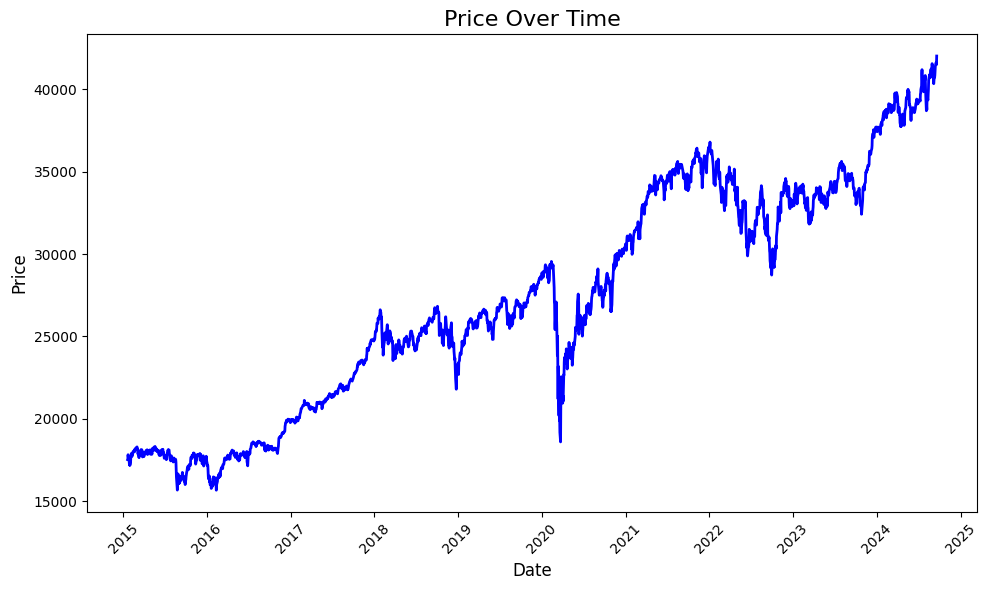

In [27]:

# Plotting Date vs Price
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(data['Date'], data['Price'], color='blue', linewidth=2)

# Adding title and labels
plt.title('Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Rotate the date labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  
plt.show()

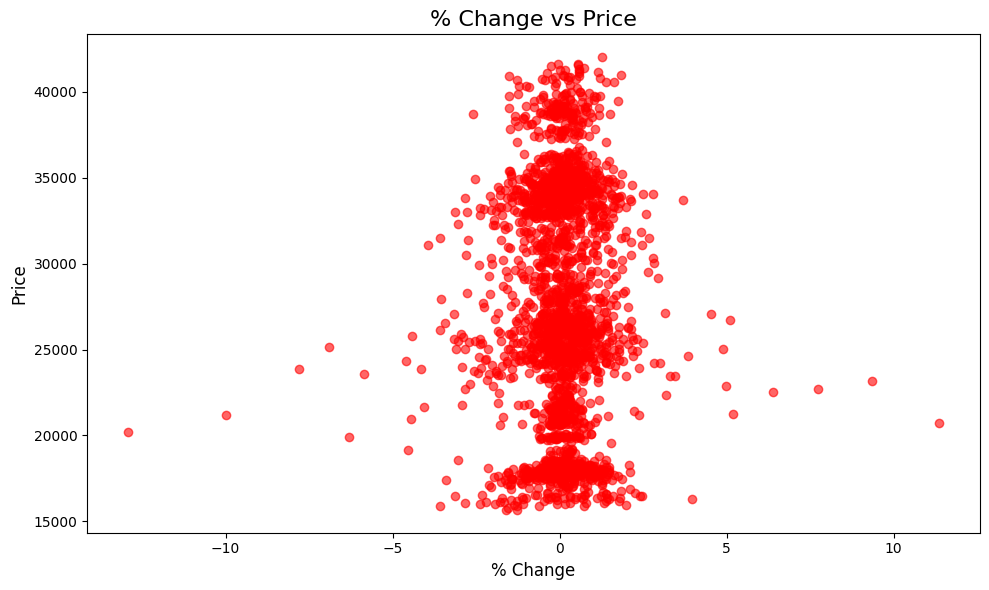

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(data['Change %'], data['Price'], color='red', alpha=0.6)
plt.title('% Change vs Price', fontsize=16)
plt.xlabel('% Change', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.show()


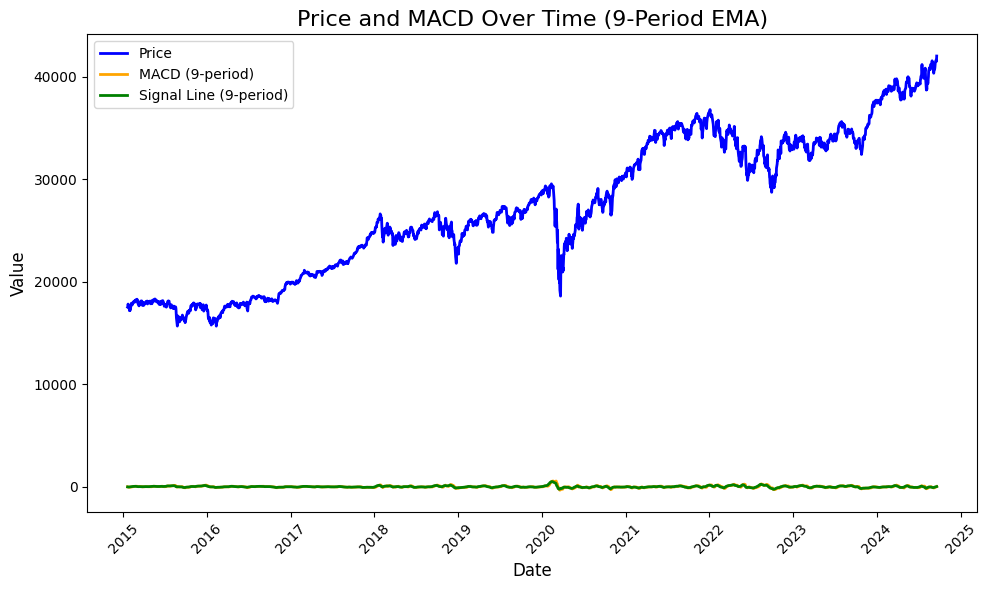

In [29]:
plt.figure(figsize=(10, 6))

# Calculating the Exponential Moving Averages (EMA) with new periods
data['EMA_9'] = data['Price'].ewm(span=9, adjust=False).mean()  # 9-period EMA
data['EMA_12'] = data['Price'].ewm(span=12, adjust=False).mean()  # 12-period EMA

# Calculating the MACD and Signal Line using 9-period and 12-period EMAs
data['MACD'] = data['EMA_9'] - data['EMA_12']  # MACD based on the new periods
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()  # 9-period Signal Line

# Plotting the price, MACD, and Signal Line
plt.plot(data['Date'], data['Price'], label='Price', color='blue', linewidth=2)
plt.plot(data['Date'], data['MACD'], label='MACD (9-period)', color='orange', linewidth=2)

# Plotting signal line for better comparison 
plt.plot(data['Date'], data['Signal_Line'], label='Signal Line (9-period)', color='green', linewidth=2)

# Adding title and labels
plt.title('Price and MACD Over Time (9-Period EMA)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Display legend and format plot
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()



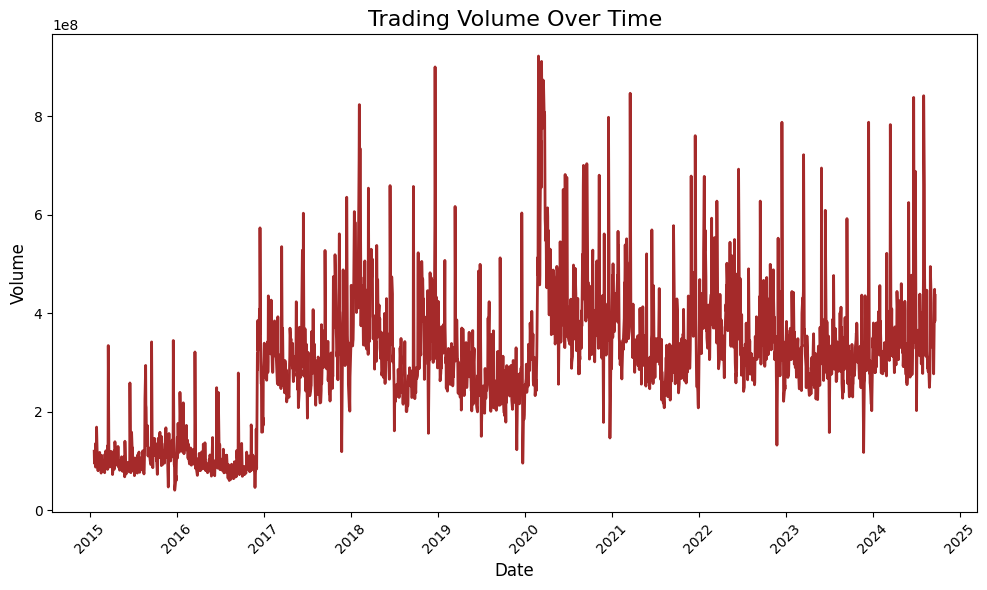

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Vol.'], color='brown', linewidth=2)  
plt.title('Trading Volume Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [20]:
print(data.columns)


Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')


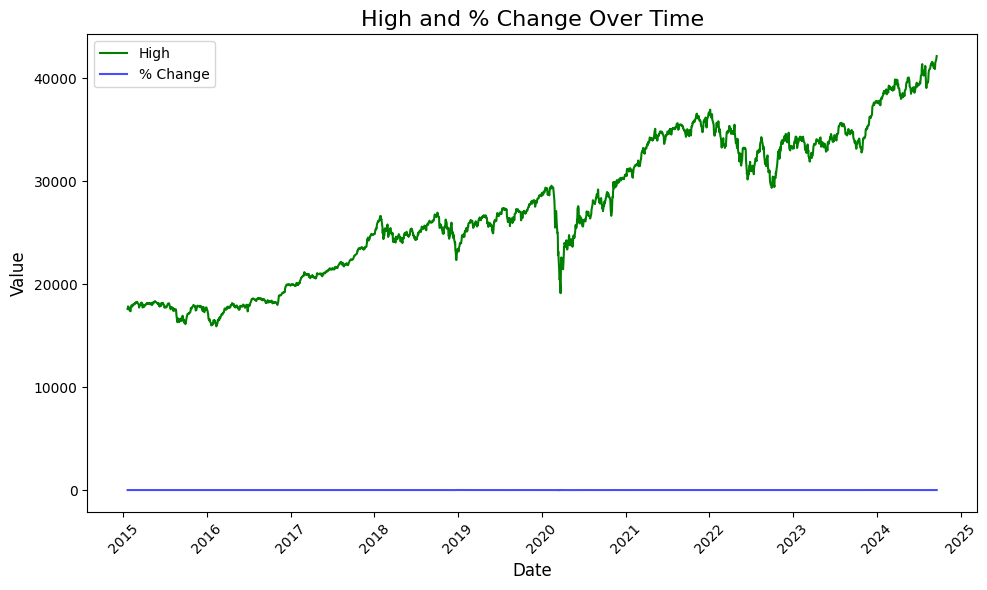

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['High'], label='High', color='green')
plt.plot(data['Date'], data['Change %'], label='% Change', color='blue', alpha=0.7)
plt.title('High and % Change Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


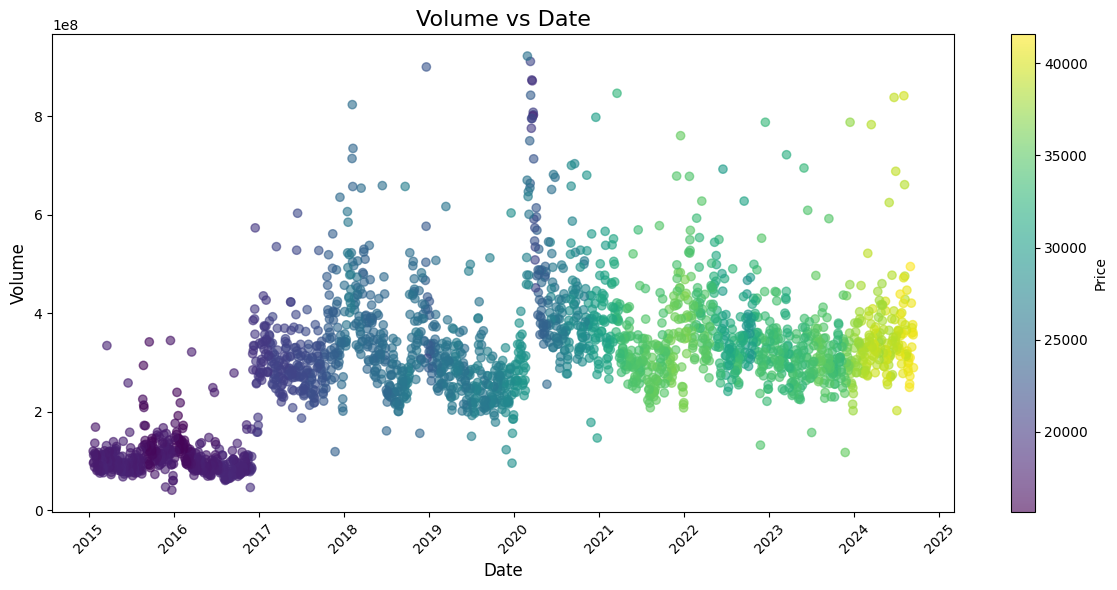

In [44]:
# scatter plot with Date on the x-axis and Price as hue
plt.figure(figsize=(12, 6))
scatter = plt.scatter(data['Date'], data['Vol.'], c=data['Price'], cmap='viridis', alpha=0.6)
plt.title('Volume vs Date', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.colorbar(scatter, label='Price')  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

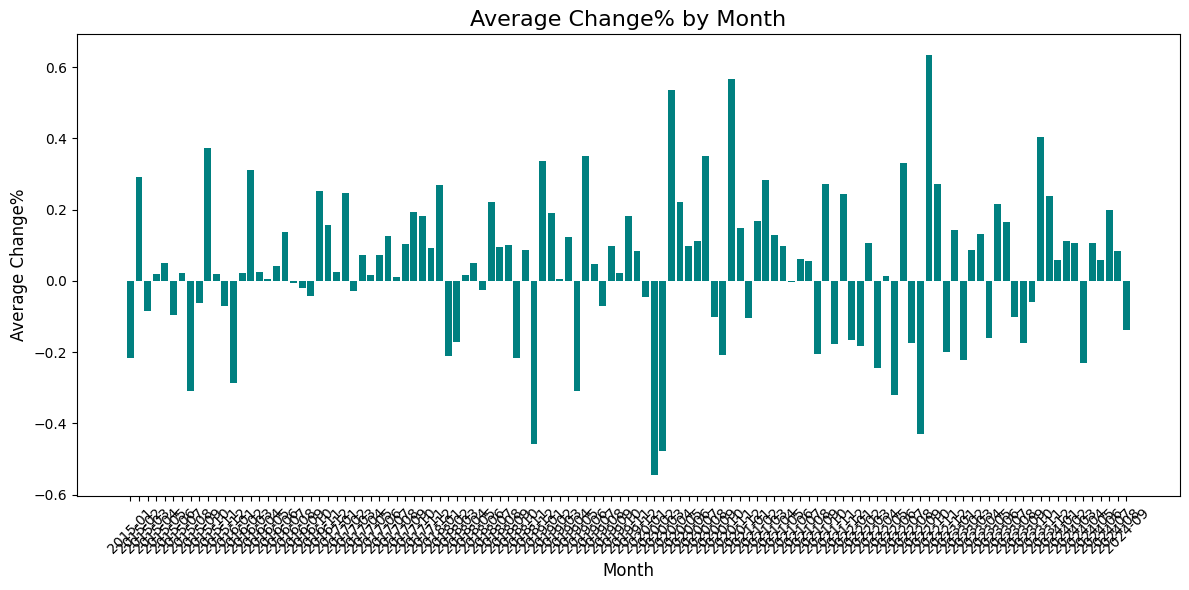

In [42]:
# Extract month and year from Date
data['YearMonth'] = data['Date'].dt.to_period('M')

# Group by YearMonth and calculate the average Change%
monthly_change = data.groupby('YearMonth')['Change %'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(monthly_change['YearMonth'].astype(str), monthly_change['Change %'], color='teal')
plt.title('Average Change% by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Change%', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



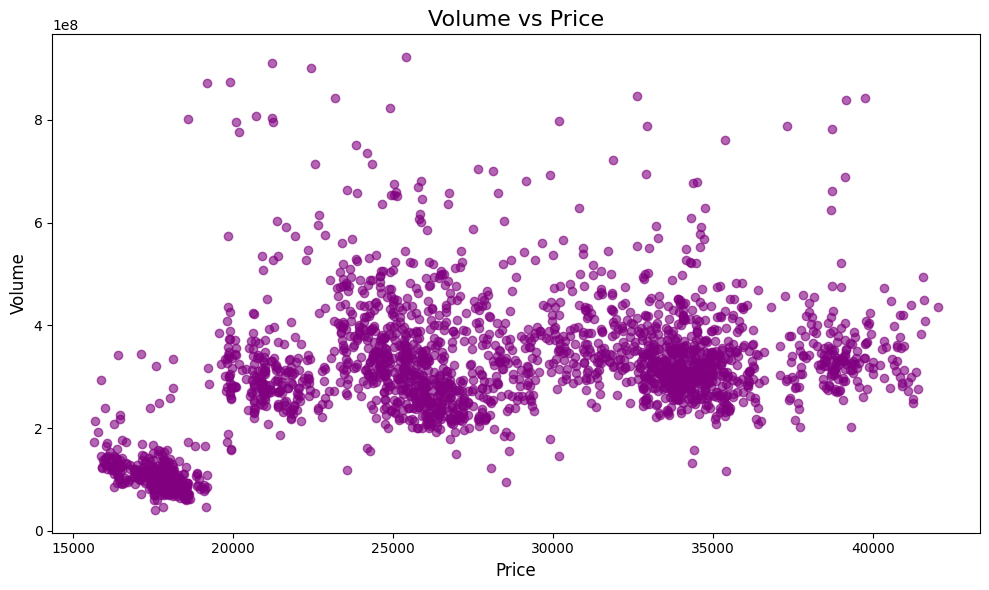

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(data['Price'], data['Vol.'], color='purple', alpha=0.6)
plt.title('Volume vs Price', fontsize=16)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.tight_layout()
plt.show()


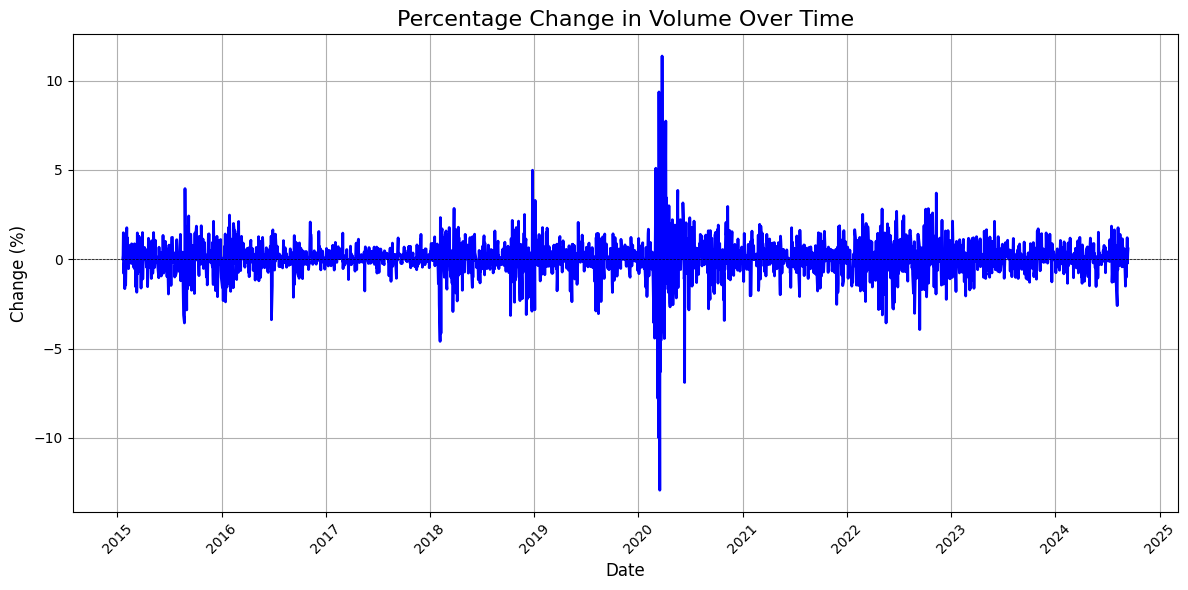

In [37]:

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Change %'], color='blue', linewidth=2)
plt.title('Percentage Change in Volume Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Change (%)', fontsize=12)
plt.xticks(rotation=45)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Line at y=0 for reference
plt.grid()
plt.tight_layout()
plt.show()


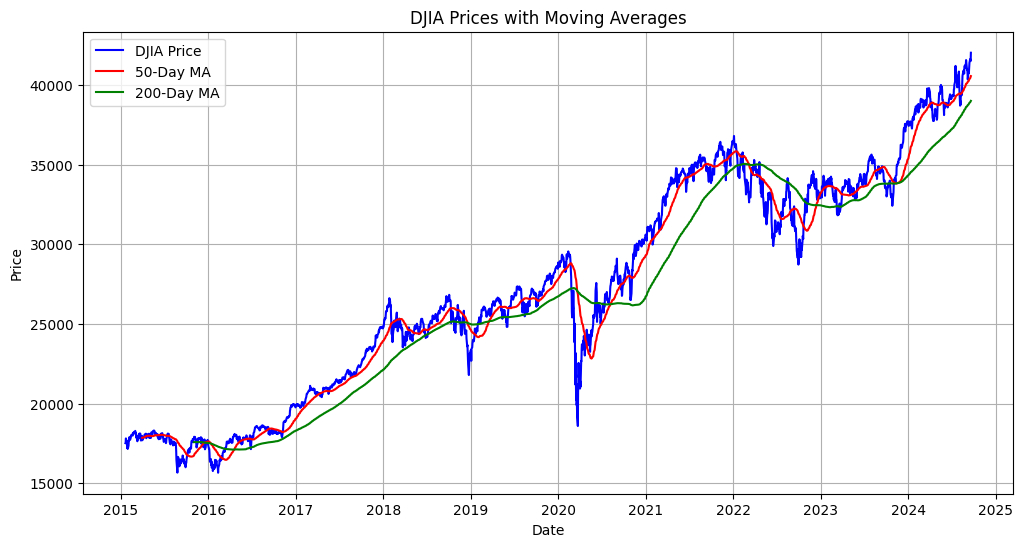

In [13]:
# Calculating 50-day and 200-day moving averages
djia_data['50_MA'] = djia_data['Price'].rolling(window=50).mean()
djia_data['200_MA'] = djia_data['Price'].rolling(window=200).mean()

# Plotting Price with Moving Averages
plt.figure(figsize=(12,6))
plt.plot(djia_data['Date'], djia_data['Price'], label='DJIA Price', color='blue')
plt.plot(djia_data['Date'], djia_data['50_MA'], label='50-Day MA', color='red')
plt.plot(djia_data['Date'], djia_data['200_MA'], label='200-Day MA', color='green')
plt.title('DJIA Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2429 entries, 2024-09-12 to 2015-01-20
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Price           2429 non-null   float64
 1   Open            2429 non-null   float64
 2   High            2429 non-null   float64
 3   Low             2429 non-null   float64
 4   Vol.            2429 non-null   float64
 5   Change %        2429 non-null   float64
 6   Price_Lag_1     2429 non-null   object 
 7   Price_Lag_2     2429 non-null   object 
 8   Change_Lag_1    2429 non-null   object 
 9   Rolling_Mean_5  2429 non-null   float64
 10  Rolling_Std_5   2429 non-null   float64
 11  Year            2429 non-null   int32  
 12  Month           2429 non-null   int32  
 13  Day             2429 non-null   int32  
 14  Day_of_Week     2429 non-null   int32  
 15  Is_Weekend      2429 non-null   int32  
 16  Pct_Change_5    2429 non-null   float64
 17  Volatility_5   

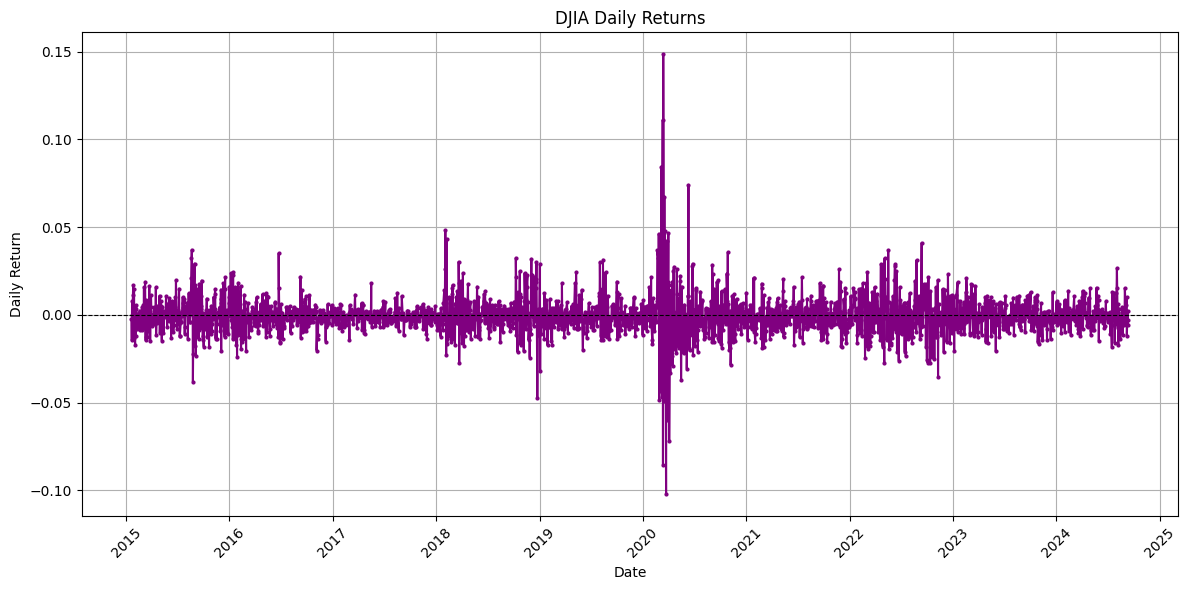

In [16]:
# DJIA Daily Returns
data['Daily_Returns'] = data['Price'].pct_change()
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Daily_Returns'], color='purple', marker='o', markersize=2)
plt.title('DJIA Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


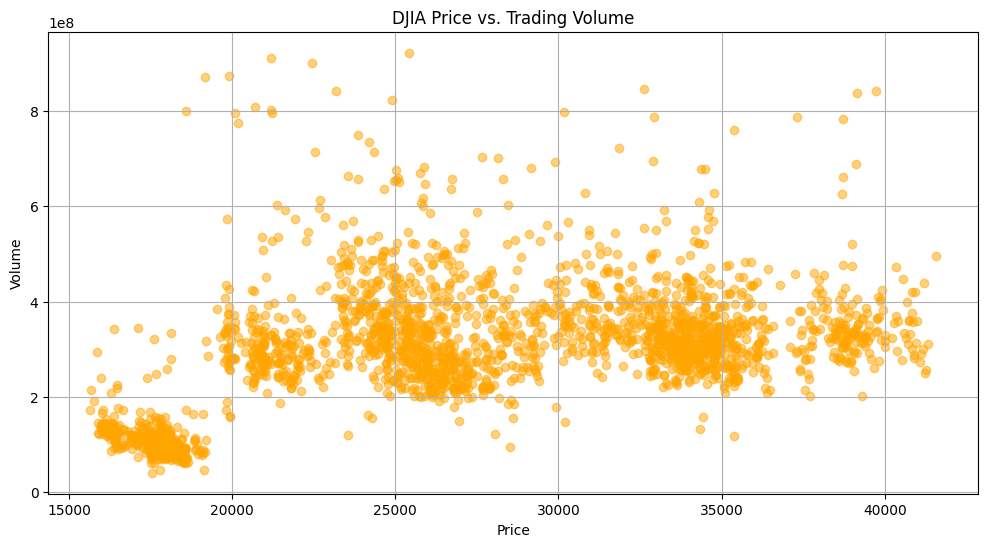

In [18]:
# DJIA Price vs. Trading Volume
plt.figure(figsize=(12, 6))
plt.scatter(data['Price'], data['Vol.'], alpha=0.5, color='orange')
plt.title('DJIA Price vs. Trading Volume')
plt.xlabel('Price')
plt.ylabel('Volume')
plt.grid()
plt.show()


Price             float64
Open              float64
High              float64
Low               float64
Vol.              float64
Change %          float64
Price_Lag_1       float64
Price_Lag_2       float64
Change_Lag_1       object
Rolling_Mean_5    float64
Rolling_Std_5     float64
Year                int64
Month               int64
Day                 int64
Day_of_Week         int64
Is_Weekend          int32
Pct_Change_5      float64
Volatility_5      float64
Daily_Returns     float64
EMA_12            float64
EMA_26            float64
MACD              float64
Signal_Line       float64
dtype: object


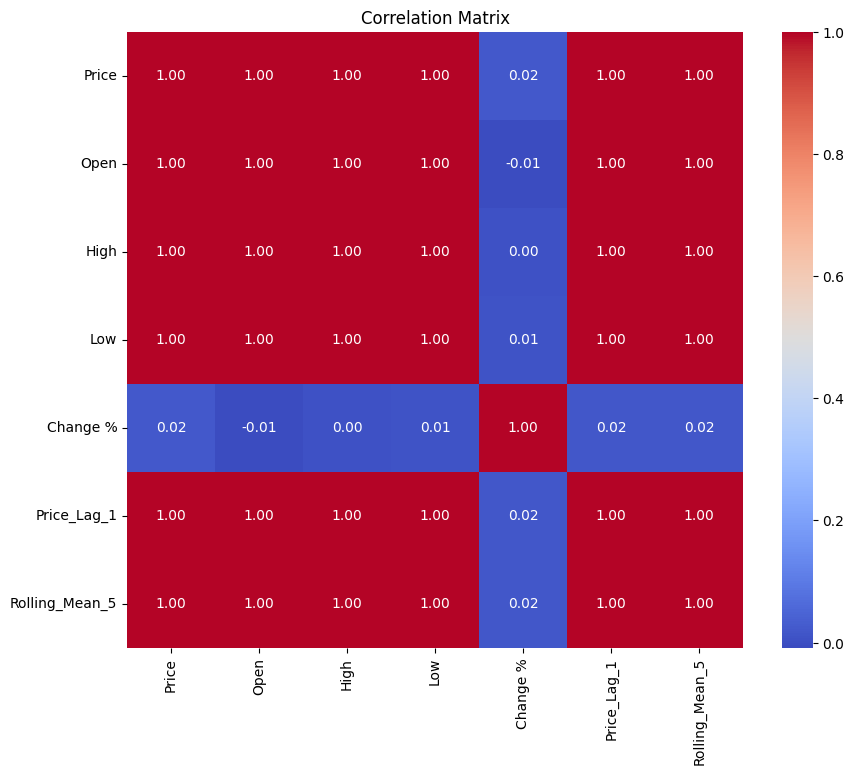

In [20]:

columns_to_clean = ['Price', 'Open', 'High', 'Low', 'Price_Lag_1', 'Price_Lag_2', 'Change %']

# Cleaning columns by removing commas and converting to float
for col in columns_to_clean:
    data[col] = data[col].astype(str).str.replace(',', '').astype(float)

# Checking data types again to confirm all columns are now numeric
print(data.dtypes)

# Now computing the correlation matrix 
import seaborn as sns
import matplotlib.pyplot as plt

# Calculating the correlation matrix for the cleaned numeric columns
correlation_matrix = data[['Price', 'Open', 'High', 'Low', 'Change %', 'Price_Lag_1', 'Rolling_Mean_5']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()


Features and Target Variable

In [21]:
from sklearn.model_selection import train_test_split

# Features and target variable
features = data[['Price_Lag_1', 'Price_Lag_2', 'Rolling_Mean_5', 'Year', 'Month', 'Day_of_Week', 'Is_Weekend']]
target = data['Price']



Splitting data into training and testing sets 

In [22]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [32]:
# 80% train, 20% test
split_ratio = 0.8
split_index = int(len(data) * split_ratio)

train = data.iloc[:split_index]
test = data.iloc[split_index:]

Linear Regression Model

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Training Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Making predictions
lr_predictions = lr_model.predict(X_test)

# Evaluating Linear Regression
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

print(f"Linear Regression - MAE: {lr_mae}, MSE: {lr_mse}, R²: {lr_r2}")


Linear Regression - MAE: 172.56825324924395, MSE: 71279.92904838652, R²: 0.998454019184163


Random forest Regressor

In [24]:
from sklearn.ensemble import RandomForestRegressor

# Training Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Making predictions
rf_predictions = rf_model.predict(X_test)

# Evaluating Random Forest
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print(f"Random Forest - MAE: {rf_mae}, MSE: {rf_mse}, R²: {rf_r2}")


Random Forest - MAE: 203.74978024691288, MSE: 87553.5290687117, R²: 0.9981010632571313


Support Vector Regressor

In [25]:
from sklearn.svm import SVR

# Training SVR model
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)

# Making predictions
svr_predictions = svr_model.predict(X_test)

# Evaluating SVR
svr_mae = mean_absolute_error(y_test, svr_predictions)
svr_mse = mean_squared_error(y_test, svr_predictions)
svr_r2 = r2_score(y_test, svr_predictions)

print(f"Support Vector Regressor - MAE: {svr_mae}, MSE: {svr_mse}, R²: {svr_r2}")


Support Vector Regressor - MAE: 5667.741186247612, MSE: 43416992.702961005, R²: 0.05833467153779204


XGBoost

In [26]:
import xgboost as xgb

# Training XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Making predictions
xgb_predictions = xgb_model.predict(X_test)

# Evaluating XGBoost
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print(f"XGBoost - MAE: {xgb_mae}, MSE: {xgb_mse}, R²: {xgb_r2}")


XGBoost - MAE: 218.6100095646863, MSE: 99557.5156666649, R²: 0.9978407104026636


In [27]:
# Setting frequency to daily
data = data.asfreq('D')


Null Hypothesis: The time series has a unit root (i.e., it is non-stationary).
Alternative Hypothesis: The time series does not have a unit root (i.e., it is stationary)

In [28]:
# Checking for NaN values
print("NaN values:", data['Price'].isnull().sum())

# Checking for infinite values
print("Infinite values:", np.isinf(data['Price']).sum())

# Cleaning the data by replacing NaN values with the mean or median
data['Price'] = data['Price'].fillna(data['Price'].mean())

# calling adfuller function
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


NaN values: 1095
Infinite values: 0
ADF Statistic: -0.412627282230837
p-value: 0.9079690293021068


In [29]:
# Creating a differenced series
data['Price_Diff'] = data['Price'].diff()

# Dropping NaN values
data = data.dropna(subset=['Price_Diff'])


In [30]:
result = adfuller(data['Price_Diff'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -13.532815397207031
p-value: 2.6017838716224897e-25


ARIMA Model

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2818
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -25593.023
Date:                Mon, 23 Sep 2024   AIC                          51198.046
Time:                        20:12:20   BIC                          51233.707
Sample:                    01-21-2015   HQIC                         51210.914
                         - 10-08-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2445      0.003    364.594      0.000       1.238       1.251
ar.L2         -0.9912      0.003   -302.813      0.000      -0.998      -0.985
ma.L1         -2.2193      0.017   -132.654      0.0

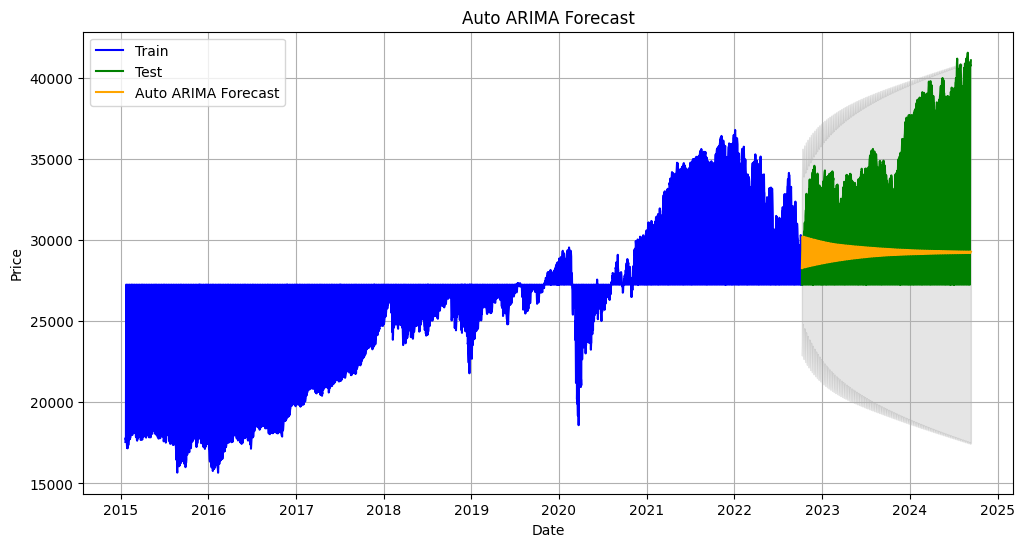

In [33]:
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Fitting the Auto ARIMA model
auto_arima_model = pm.auto_arima(train['Price'], start_p=1, start_q=1,
                                 test='adf',
                                 max_p=3, max_q=3,
                                 seasonal=False,
                                 stepwise=True)

# Printing summary of the auto_arima model
print(auto_arima_model.summary())

# Making forecasts
n_periods = len(test)
arima_forecast, conf_int = auto_arima_model.predict(n_periods=n_periods, return_conf_int=True)

# Converting forecast to Pandas Series for ease of plotting and evaluation
arima_forecast_index = test.index
arima_forecast_series = pd.Series(arima_forecast, index=arima_forecast_index)

# Evaluating the Auto ARIMA model
arima_mae = mean_absolute_error(test['Price'], arima_forecast_series)
arima_mse = mean_squared_error(test['Price'], arima_forecast_series)
arima_r2 = r2_score(test['Price'], arima_forecast_series)

print(f"Auto ARIMA - MAE: {arima_mae:.4f}, MSE: {arima_mse:.4f}, R²: {arima_r2:.4f}")

# Plotting Auto ARIMA Forecast vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(train['Price'], label='Train', color='blue')
plt.plot(test['Price'], label='Test', color='green')
plt.plot(arima_forecast_series.index, arima_forecast_series, label='Auto ARIMA Forecast', color='orange')
plt.fill_between(arima_forecast_series.index, 
                 conf_int[:, 0], 
                 conf_int[:, 1], color='k', alpha=.1)
plt.title('Auto ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


Sarima Model

SARIMA - MAE: 5494.6868, MSE: 48066948.8067, R²: -1.2773


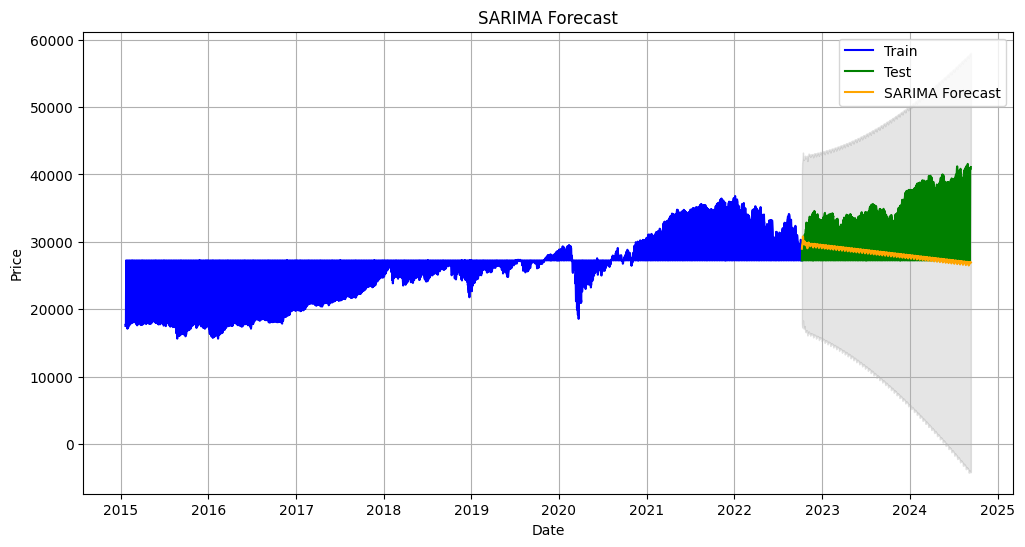

In [36]:
# Fitting the SARIMA model
sarima_model = SARIMAX(train['Price'], 
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_fit = sarima_model.fit()

# Forecasting
sarima_forecast = sarima_fit.get_forecast(steps=len(test))
sarima_forecast_ci = sarima_forecast.conf_int()

# Extracting the predicted mean and confidence intervals
sarima_predicted_mean = sarima_forecast.predicted_mean

# Evaluating the SARIMA model
sarima_mae = mean_absolute_error(test['Price'], sarima_predicted_mean)
sarima_mse = mean_squared_error(test['Price'], sarima_predicted_mean)
sarima_r2 = r2_score(test['Price'], sarima_predicted_mean)

print(f"SARIMA - MAE: {sarima_mae:.4f}, MSE: {sarima_mse:.4f}, R²: {sarima_r2:.4f}")

# Plotting SARIMA Forecast
plt.figure(figsize=(12, 6))
plt.plot(train['Price'], label='Train', color='blue')
plt.plot(test['Price'], label='Test', color='green')
plt.plot(sarima_predicted_mean.index, sarima_predicted_mean, label='SARIMA Forecast', color='orange')
plt.fill_between(sarima_predicted_mean.index,
                 sarima_forecast_ci.iloc[:, 0],
                 sarima_forecast_ci.iloc[:, 1], color='k', alpha=.1)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


In [37]:
sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                 2818
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -27000.236
Date:                            Mon, 23 Sep 2024   AIC                          54010.471
Time:                                    20:15:25   BIC                          54040.142
Sample:                                01-21-2015   HQIC                         54021.183
                                     - 10-08-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4163      0.067      6.186      0.000       0.284       0.548
ma.L1         -0.9693      0.026    -37.263      0.000      -1.020      -0.918
ar.S.L12      -0.3431      0.066     -5.227      0.000      -0.472      -0.214
ma.S.L12      -0.9576      0.021    -45.451      0.000      -0.999      -0.916
sigma2      3.183e+07   7.15e-10   4.45e+16      0.000    3.18e+07    3.18e+07
===================================================================================
Ljung-Box (L1) (Q):                  59.52   Jarque-Bera (JB):               389.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.03e+31. Standard errors may be unstable.
"""

Prophet model 

In [38]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

# Preparing the data for Prophet
prophet_data = pd.DataFrame()
prophet_data['ds'] = data.index  
prophet_data['y'] = data['Price']  

prophet_data = prophet_data.dropna()



In [39]:
# Checking for NaNs in the Price column
print(data['Price'].isna().sum())
print(data['Price'].head())


0
Date
2015-01-21    17554.2800
2015-01-22    17813.9800
2015-01-23    17672.6000
2015-01-24    27259.8514
2015-01-25    27259.8514
Freq: D, Name: Price, dtype: float64


In [40]:
# Preparing the data for Prophet
prophet_data = pd.DataFrame({
    'ds': data.index,  
    'y': data['Price']  
})

# Dropping rows with NaN values in 'y'
prophet_data = prophet_data.dropna()


In [41]:
###############################################
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

# Checking the original data for NaNs
print("Original data NaNs:", data['Price'].isna().sum())

# Prepare the data for Prophet
prophet_data = pd.DataFrame({
    'ds': data.index,
    'y': data['Price']
})

# Dropping rows with NaN values
prophet_data = prophet_data.dropna()

# Checking the resulting DataFrame
print("Prophet data shape:", prophet_data.shape)
print(prophet_data.head())

# Ensuring enough data to fit the model
if prophet_data.shape[0] < 2:
    raise ValueError("Not enough non-NaN rows to fit the model.")

# Initialising and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Forecasting future values matching the length of the test set
future_dates = prophet_model.make_future_dataframe(periods=len(y_test))
prophet_forecast = prophet_model.predict(future_dates)

# Extracting forecasted values (yhat) for the test set period
forecasted_values = prophet_forecast['yhat'][-len(y_test):].values

# Evaluating Prophet's forecast
prophet_mae = mean_absolute_error(y_test, forecasted_values)
prophet_mse = mean_squared_error(y_test, forecasted_values)
prophet_r2 = r2_score(y_test, forecasted_values)

print(f"Prophet - MAE: {prophet_mae:.4f}, MSE: {prophet_mse:.4f}, R²: {prophet_r2:.4f}")



Original data NaNs: 0
Prophet data shape: (3523, 2)
                   ds           y
Date                             
2015-01-21 2015-01-21  17554.2800
2015-01-22 2015-01-22  17813.9800
2015-01-23 2015-01-23  17672.6000
2015-01-24 2015-01-24  27259.8514
2015-01-25 2015-01-25  27259.8514


20:15:41 - cmdstanpy - INFO - Chain [1] start processing
20:15:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet - MAE: 10395.4205, MSE: 150742836.7137, R²: -2.2694


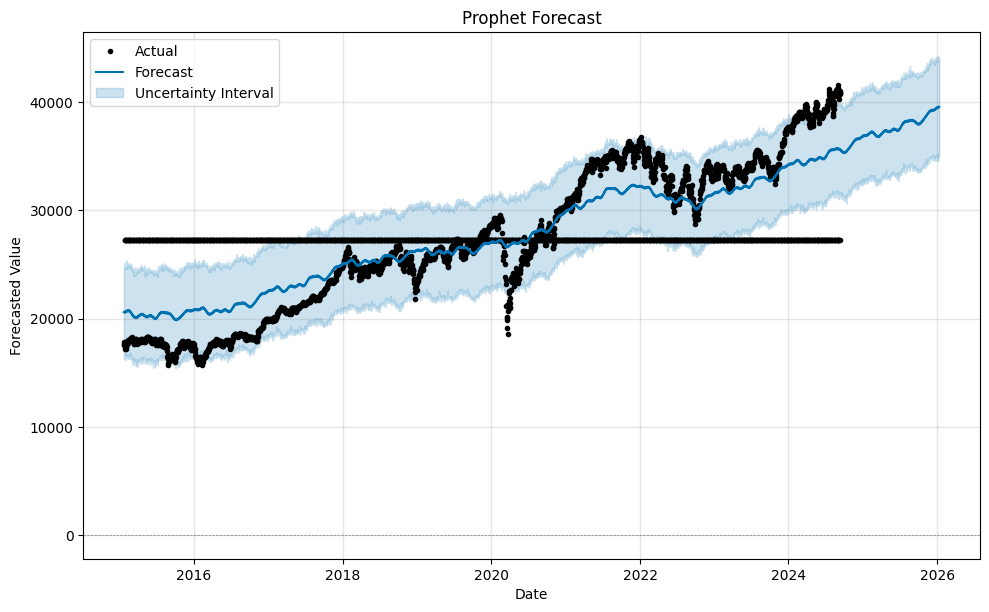

In [42]:
# Plotting the forecast
fig = prophet_model.plot(prophet_forecast)

# Adding labels and legends
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Forecasted Value')

# Add a legend for the plot elements
plt.legend(['Actual', 'Forecast', 'Uncertainty Interval'])

plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.show()

20:17:32 - cmdstanpy - INFO - Chain [1] start processing
20:17:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet - MAE: 4978.5316, MSE: 30220703.4175, R²: -0.4318


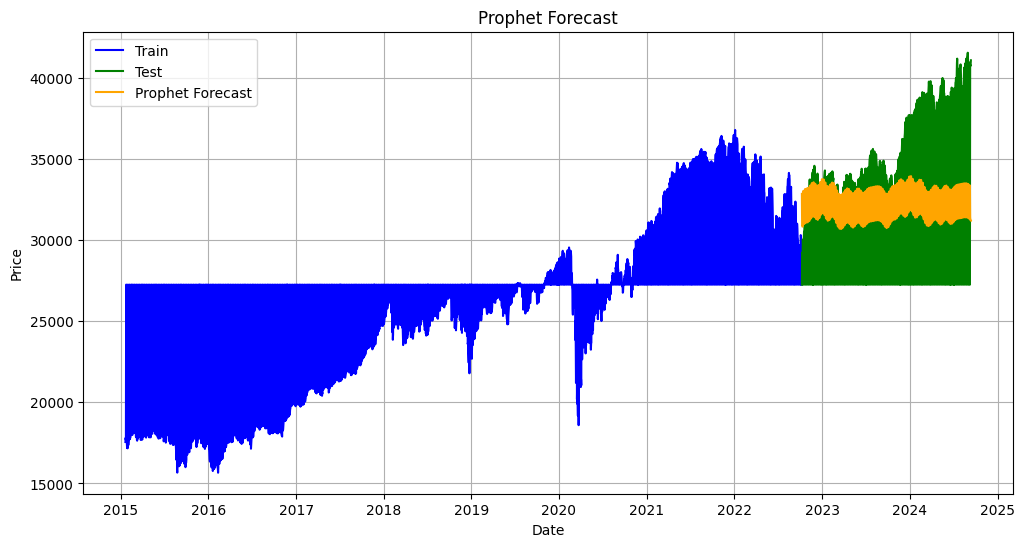

In [43]:
# Prepareing the data for Prophet
df_train = train.reset_index()[['Date', 'Price']].rename(columns={'Date': 'ds', 'Price': 'y'})

# Initializing and fit the model
prophet_model = Prophet()
prophet_model.fit(df_train)

# Preparing test data for prediction
future_dates = prophet_model.make_future_dataframe(periods=len(test), freq='D')

# Forecasting
prophet_forecast = prophet_model.predict(future_dates)

# Evaluating Prophet's forecast
prophet_forecast_filtered = prophet_forecast[['ds', 'yhat']].set_index('ds').iloc[-len(test):]
prophet_mae = mean_absolute_error(test['Price'], prophet_forecast_filtered['yhat'])
prophet_mse = mean_squared_error(test['Price'], prophet_forecast_filtered['yhat'])
prophet_r2 = r2_score(test['Price'], prophet_forecast_filtered['yhat'])

print(f"Prophet - MAE: {prophet_mae:.4f}, MSE: {prophet_mse:.4f}, R²: {prophet_r2:.4f}")

# Plotting the Prophet forecast
plt.figure(figsize=(12, 6))
plt.plot(train['Price'], label='Train', color='blue')
plt.plot(test['Price'], label='Test', color='green')
plt.plot(prophet_forecast_filtered.index, prophet_forecast_filtered['yhat'], label='Prophet Forecast', color='orange')
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


Exponential Smoothing

ETS - MAE: 5236.9001, MSE: 39179039.7323, R²: -0.8562


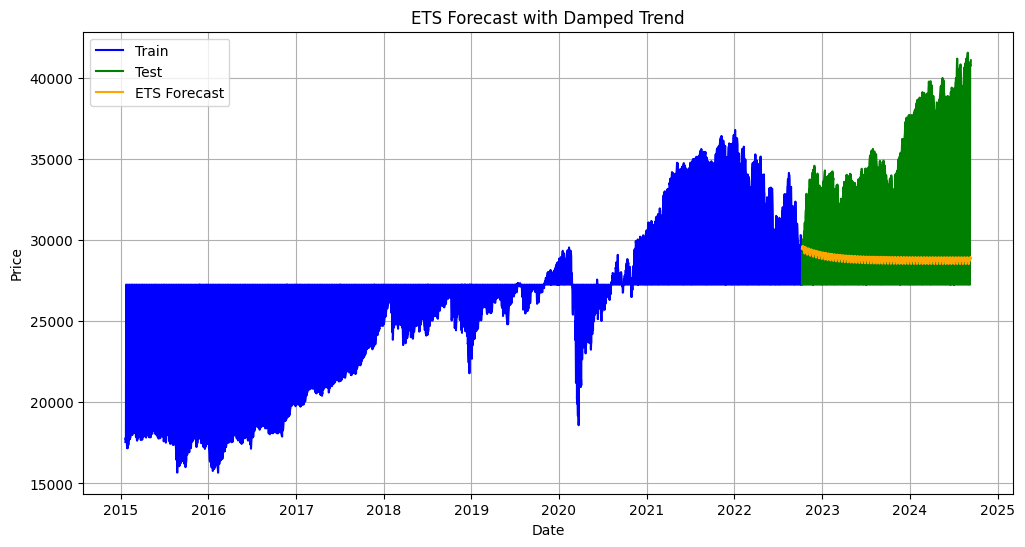

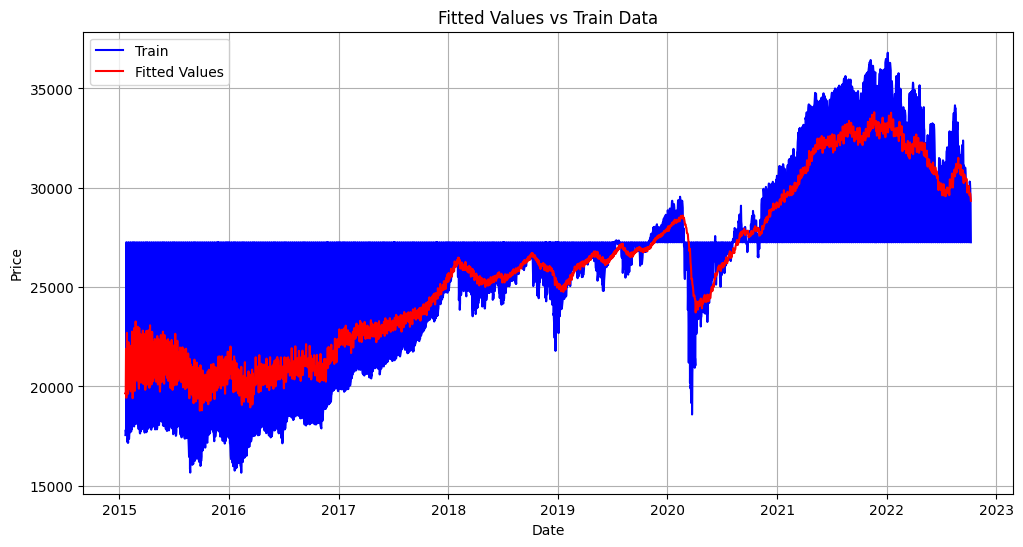

In [45]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fitting the ETS model with a damped trend
ets_model = ExponentialSmoothing(
    train['Price'],
    trend='add',
    damped_trend=True,
    seasonal='add',
    seasonal_periods=12
)
ets_fit = ets_model.fit()

# Making predictions
ets_forecast = ets_fit.forecast(steps=len(test))

# Evaluating ETS
ets_mae = mean_absolute_error(test['Price'], ets_forecast)
ets_mse = mean_squared_error(test['Price'], ets_forecast)
ets_r2 = r2_score(test['Price'], ets_forecast)

print(f"ETS - MAE: {ets_mae:.4f}, MSE: {ets_mse:.4f}, R²: {ets_r2:.4f}")

# Plotting the forecast
plt.figure(figsize=(12, 6))
plt.plot(train['Price'], label='Train', color='blue')
plt.plot(test['Price'], label='Test', color='green')
plt.plot(ets_forecast.index, ets_forecast, label='ETS Forecast', color='orange')
plt.title('ETS Forecast with Damped Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Plotting fitted values
plt.figure(figsize=(12, 6))
plt.plot(train['Price'], label='Train', color='blue')
plt.plot(ets_fit.fittedvalues, label='Fitted Values', color='red')
plt.title('Fitted Values vs Train Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


In [46]:
# Model Summary
ets_fit.summary()

Dep. Variable:,Price,No. Observations:,2818
Model:,ExponentialSmoothing,SSE,26037746149.987
Optimized:,True,AIC,45231.988
Trend:,Additive,BIC,45333.032
Seasonal:,Additive,AICC,45232.259
Seasonal Periods:,12,Date:,"Mon, 23 Sep 2024"
Box-Cox:,False,Time:,20:21:11
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0403571,alpha,True
smoothing_trend,0.0080714,beta,True
